In [1]:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# Import some common libraries
import numpy as np
import os, json, cv2, random
from matplotlib import pyplot as plt

# Import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog


# Import util functions
import utils

/opt/anaconda3/envs/rhexis_project/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
utils.load_datasets_pipeline()

[05/03 13:11:08 d2.data.datasets.coco]: Loaded 320 images in COCO format from /Users/benehlert/Desktop/Classes/CS231N/rhexis-trajectory/datasets/train_set/train_coco_kp_bbox_annotations3.json


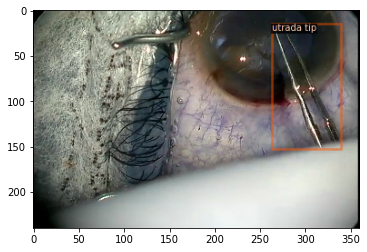

In [5]:
# visualize training data
dataset_dicts = DatasetCatalog.get("train") 
train_metadata = MetadataCatalog.get("train")

for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=train_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    plt.imshow(vis.get_image()[:, :,::-1])

In [12]:
# Fine-tune COCO-pretrained R50-FPN Keypoint RCNN on dataset

from detectron2.engine import DefaultTrainer

cfg = get_cfg()
cfg.MODEL.DEVICE = 'cpu'
cfg.merge_from_file(model_zoo.get_config_file("COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("train_dataset",)
cfg.DATASETS.TEST = () # "my_dataset_val",
cfg.DATALOADER.NUM_WORKERS = 1
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.000025  # pick a good LR
cfg.SOLVER.MAX_ITER = 2    # 300 was good for balloon toy dataset. Adjust up if val mAP is still rising, adjust down if overfit
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for balloon toy dataset (default: 512)

cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (utrada tip). (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)
# NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrect uses num_classes+1 here.  
cfg.MODEL.KEYPOINT_ON = True
cfg.MODEL.ROI_KEYPOINT_HEAD.NUM_KEYPOINTS = 2
cfg.TEST.KEYPOINT_OKS_SIGMAS = [1.0, 1.0] 

# cfg.DATALOADER.FILTER_EMPTY_ANNOTATIONS = False # keep and do not exclude images labeled to have no objects

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[05/03 12:36:23 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

[05/03 12:36:23 d2.data.datasets.coco]: Loaded 320 images in COCO format from /Users/benehlert/Desktop/Classes/CS231N/rhexis-trajectory/datasets/train_set/train_coco_kp_bbox_annotations3.json
[05/03 12:36:23 d2.data.build]: Removed 15 images with no usable annotations. 305 images left.
[05/03 12:36:23 d2.data.build]: Removed 6 images with fewer than 1 keypoints.
[05/03 12:36:23 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[05/03 12:36:23 d2.data.build]: Using training sampler TrainingSampler
[05/03 12:36:23 d2.data.common]: Serializing 299 elements to byte tensors and concatenating them all ...
[05/03 12:36:23 d2.data.common]: Serialized dataset takes 0.11 MiB


Skip loading parameter 'roi_heads.keypoint_head.score_lowres.weight' to the model due to incompatible shapes: (512, 17, 4, 4) in the checkpoint but (512, 2, 4, 4) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.keypoint_head.score_lowres.bias' to the model due to incompatible shapes: (17,) in the checkpoint but (2,) in the model! You might want to double check if this is expected.
Some model parameters or buffers are not found in the checkpoint:
roi_heads.keypoint_head.score_lowres.{bias, weight}


[05/03 12:36:23 d2.engine.train_loop]: Starting training from iteration 0


/opt/anaconda3/envs/rhexis_project/lib/python3.10/site-packages/detectron2/structures/keypoints.py:29: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /Users/distiller/project/conda/conda-bld/pytorch_1646756028548/work/torch/csrc/utils/tensor_new.cpp:210.)
  keypoints = torch.as_tensor(keypoints, dtype=torch.float32, device=device)


[05/03 12:37:28 d2.utils.events]:  iter: 1  total_loss: 8.946  loss_cls: 0.4931  loss_box_reg: 0.3843  loss_keypoint: 8.031  loss_rpn_cls: 0.02519  loss_rpn_loc: 0.0124  data_time: 1.1713  lr: 1.2512e-05  
[05/03 12:37:28 d2.engine.hooks]: Total training time: 0:00:00 (0:00:00 on hooks)


In [13]:
# Look at training curves in tensorboard:
%load_ext tensorboard
%tensorboard --logdir output

In [15]:
# Inference should use the config with parameters that are used in training
# cfg now already contains everything we've set previously. We changed it a little bit for inference:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

[05/03 12:37:51 d2.checkpoint.c2_model_loading]: Following weights matched with model:
| Names in Model                                  | Names in Checkpoint                                                                                  | Shapes                                          |
|:------------------------------------------------|:-----------------------------------------------------------------------------------------------------|:------------------------------------------------|
| backbone.bottom_up.res2.0.conv1.*               | backbone.bottom_up.res2.0.conv1.{norm.bias,norm.running_mean,norm.running_var,norm.weight,weight}    | (64,) (64,) (64,) (64,) (64,64,1,1)             |
| backbone.bottom_up.res2.0.conv2.*               | backbone.bottom_up.res2.0.conv2.{norm.bias,norm.running_mean,norm.running_var,norm.weight,weight}    | (64,) (64,) (64,) (64,) (64,64,3,3)             |
| backbone.bottom_up.res2.0.conv3.*               | backbone.bottom_up.res2.0.conv3.{norm.bia

[05/03 12:49:42 d2.data.datasets.coco]: Loaded 320 images in COCO format from /Users/benehlert/Desktop/Classes/CS231N/rhexis-trajectory/datasets/train_set/train_coco_kp_bbox_annotations3.json
{'instances': Instances(num_instances=0, image_height=478, image_width=712, fields=[pred_boxes: Boxes(tensor([], size=(0, 4))), scores: tensor([]), pred_classes: tensor([], dtype=torch.int64), pred_keypoints: tensor([], size=(0, 2, 3)), pred_keypoint_heatmaps: tensor([], size=(0, 2, 56, 56))])}
{'instances': Instances(num_instances=0, image_height=480, image_width=720, fields=[pred_boxes: Boxes(tensor([], size=(0, 4))), scores: tensor([]), pred_classes: tensor([], dtype=torch.int64), pred_keypoints: tensor([], size=(0, 2, 3)), pred_keypoint_heatmaps: tensor([], size=(0, 2, 56, 56))])}
{'instances': Instances(num_instances=1, image_height=1080, image_width=1920, fields=[pred_boxes: Boxes(tensor([[  47.0737,  116.4651, 1485.1619, 1072.3077]])), scores: tensor([0.9933]), pred_classes: tensor([0]), pr

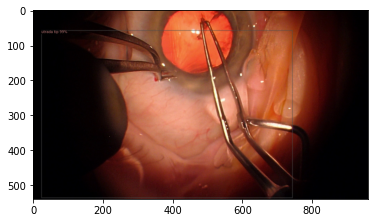

In [31]:
from detectron2.utils.visualizer import ColorMode
dataset_dicts = DatasetCatalog.get("train_dataset") 
for d in random.sample(dataset_dicts, 3):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    print(outputs)
    
    v = Visualizer(im[:, :, ::-1],
                   metadata=MetadataCatalog.get("train_dataset"), 
                   scale=0.5
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.imshow(out.get_image()[:, :, :])

In [ ]:
# Evaluate performance using COCO AP metric

from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("train_dataset", output_dir="./output", kpt_oks_sigmas=([1.0, 1.0]))

val_loader = build_detection_test_loader(cfg, "train_dataset")
print(inference_on_dataset(predictor.model, val_loader, evaluator))
# another equivalent way to evaluate the model is to use `trainer.test`

[05/03 12:50:28 d2.data.datasets.coco]: Loaded 320 images in COCO format from /Users/benehlert/Desktop/Classes/CS231N/rhexis-trajectory/datasets/train_set/train_coco_kp_bbox_annotations3.json
[05/03 12:50:28 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
| utrada tip | 305          |
|            |              |
[05/03 12:50:28 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[05/03 12:50:28 d2.data.common]: Serializing 320 elements to byte tensors and concatenating them all ...
[05/03 12:50:28 d2.data.common]: Serialized dataset takes 0.11 MiB
[05/03 12:50:28 d2.evaluation.evaluator]: Start inference on 320 batches
[05/03 12:50:35 d2.evaluation.evaluator]: Inference done 1/320. Dataloading: 2.4357 s/iter. Inference: 5.1650 s/iter. Eval: 0.0001 s/iter. Total: 7.6015 s/iter. ETA=0:40:24
[05/03 12

[05/03 12:55:06 d2.evaluation.evaluator]: Inference done 53/320. Dataloading: 0.0006 s/iter. Inference: 5.2340 s/iter. Eval: 0.0001 s/iter. Total: 5.2354 s/iter. ETA=0:23:17
[05/03 12:55:11 d2.evaluation.evaluator]: Inference done 54/320. Dataloading: 0.0006 s/iter. Inference: 5.2310 s/iter. Eval: 0.0001 s/iter. Total: 5.2324 s/iter. ETA=0:23:11
[05/03 12:55:17 d2.evaluation.evaluator]: Inference done 55/320. Dataloading: 0.0006 s/iter. Inference: 5.2314 s/iter. Eval: 0.0001 s/iter. Total: 5.2328 s/iter. ETA=0:23:06
[05/03 12:55:22 d2.evaluation.evaluator]: Inference done 56/320. Dataloading: 0.0006 s/iter. Inference: 5.2381 s/iter. Eval: 0.0001 s/iter. Total: 5.2395 s/iter. ETA=0:23:03
[05/03 12:55:28 d2.evaluation.evaluator]: Inference done 57/320. Dataloading: 0.0006 s/iter. Inference: 5.2396 s/iter. Eval: 0.0001 s/iter. Total: 5.2409 s/iter. ETA=0:22:58
[05/03 12:55:38 d2.evaluation.evaluator]: Inference done 59/320. Dataloading: 0.0006 s/iter. Inference: 5.2318 s/iter. Eval: 0.000

[05/03 12:59:31 d2.evaluation.evaluator]: Inference done 100/320. Dataloading: 0.0007 s/iter. Inference: 5.4246 s/iter. Eval: 0.0001 s/iter. Total: 5.4261 s/iter. ETA=0:19:53
[05/03 12:59:36 d2.evaluation.evaluator]: Inference done 101/320. Dataloading: 0.0007 s/iter. Inference: 5.4286 s/iter. Eval: 0.0001 s/iter. Total: 5.4300 s/iter. ETA=0:19:49
[05/03 12:59:42 d2.evaluation.evaluator]: Inference done 102/320. Dataloading: 0.0007 s/iter. Inference: 5.4290 s/iter. Eval: 0.0001 s/iter. Total: 5.4304 s/iter. ETA=0:19:43
[05/03 12:59:47 d2.evaluation.evaluator]: Inference done 103/320. Dataloading: 0.0006 s/iter. Inference: 5.4301 s/iter. Eval: 0.0001 s/iter. Total: 5.4315 s/iter. ETA=0:19:38
[05/03 12:59:54 d2.evaluation.evaluator]: Inference done 104/320. Dataloading: 0.0006 s/iter. Inference: 5.4379 s/iter. Eval: 0.0001 s/iter. Total: 5.4394 s/iter. ETA=0:19:34
[05/03 13:00:00 d2.evaluation.evaluator]: Inference done 105/320. Dataloading: 0.0007 s/iter. Inference: 5.4458 s/iter. Eval:

[05/03 13:03:57 d2.evaluation.evaluator]: Inference done 148/320. Dataloading: 0.0007 s/iter. Inference: 5.4676 s/iter. Eval: 0.0001 s/iter. Total: 5.4691 s/iter. ETA=0:15:40
[05/03 13:04:03 d2.evaluation.evaluator]: Inference done 149/320. Dataloading: 0.0007 s/iter. Inference: 5.4673 s/iter. Eval: 0.0001 s/iter. Total: 5.4687 s/iter. ETA=0:15:35
[05/03 13:04:08 d2.evaluation.evaluator]: Inference done 150/320. Dataloading: 0.0007 s/iter. Inference: 5.4653 s/iter. Eval: 0.0001 s/iter. Total: 5.4667 s/iter. ETA=0:15:29
[05/03 13:04:13 d2.evaluation.evaluator]: Inference done 151/320. Dataloading: 0.0007 s/iter. Inference: 5.4634 s/iter. Eval: 0.0001 s/iter. Total: 5.4648 s/iter. ETA=0:15:23
[05/03 13:04:18 d2.evaluation.evaluator]: Inference done 152/320. Dataloading: 0.0007 s/iter. Inference: 5.4620 s/iter. Eval: 0.0001 s/iter. Total: 5.4634 s/iter. ETA=0:15:17
[05/03 13:04:24 d2.evaluation.evaluator]: Inference done 153/320. Dataloading: 0.0007 s/iter. Inference: 5.4611 s/iter. Eval: